# gwexpy TimeSeries 新機能チュートリアル

このノートブックでは、`gwpy` を拡張した `gwexpy` の `TimeSeries` クラスに追加された新しいメソッドとその使い方を解説します。

`gwexpy` は GWpy との高い互換性を維持しつつ、信号処理、統計解析、他ライブラリとの相互運用性を大幅に強化しています。

## 目次
1. [環境セットアップ](#setup)
2. [信号処理と復調 (Hilbert, Phase, Demodulation)](#signal-processing)
3. [スペクトル解析と相関 (FFT, Transfer Function, xcorr)](#spectral)
4. [統計・前処理 (Impute, Standardize, ARIMA, Hurst, Rolling)](#stats)
5. [リサンプリングと再インデックス (asfreq, resample)](#resampling)
6. [相互運用性 (Pandas, Xarray, Torch, and more)](#interop)

<a id="setup"></a>
## 1. 環境セットアップ

まずは必要なライブラリをインポートし、デモ用のサンプルデータを生成します。

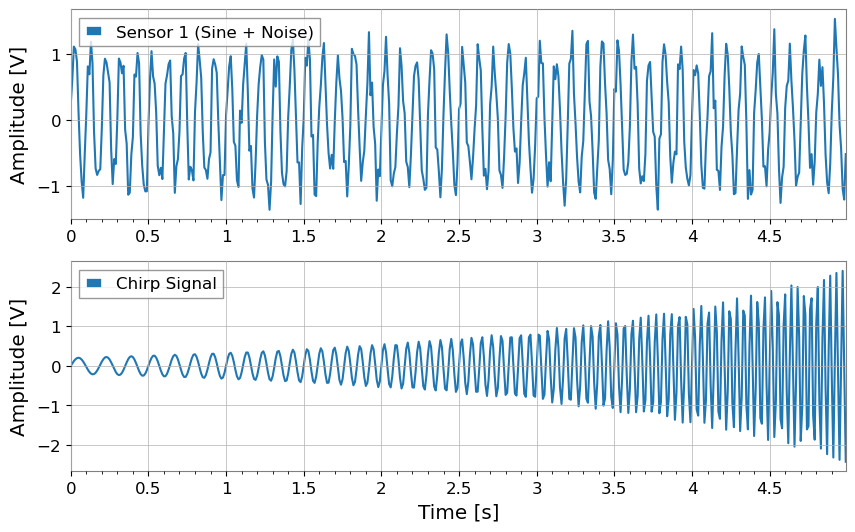

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.plot import Plot
from astropy import units as u

# サンプルデータの生成 (100Hzでサンプリングされた5秒間のデータ)
fs = 100
t = np.arange(0, 5, 1/fs)

# Sensor 1: 10Hzの正弦波 + ノイズ
data1 = np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.randn(len(t))
# Sensor 2: チャープ信号 (周波数が時間とともに変化)
data2 = np.sin(2 * np.pi * (5 + 2*t) * t) * np.exp(t/2)/5

ts1 = TimeSeries(data1, sample_rate=fs, unit='V', name='Sensor 1', t0=0)
ts2 = TimeSeries(data2, sample_rate=fs, unit='V', name='Chirp Signal', t0=0)

# プロットして確認
plot = Plot(ts1, ts2, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].set_ylabel('Amplitude [V]')
ax[0].legend(['Sensor 1 (Sine + Noise)'])
ax[1].set_ylabel('Amplitude [V]')
ax[1].legend(['Chirp Signal'])
ax[1].set_xlabel('Time [s]')
plt.show()

<a id="signal-processing"></a>
## 2. 信号処理と復調

`gwexpy` では、ヒルベルト変換や包絡線、瞬時周波数の計算、さらにロックインアンプのような復調機能が統合されています。

### ヒルベルト変換と包絡線
`hilbert` と `envelope` を使用します。

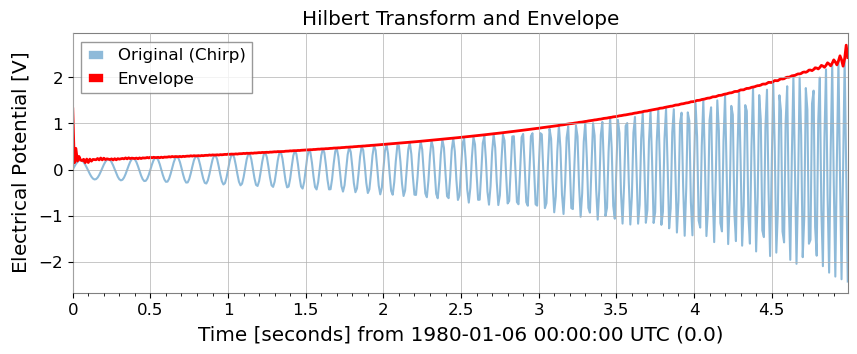

In [2]:
# 分析信号 (Analytic Signal) の計算
ts_analytic = ts2.hilbert()
# 包絡線 (Envelope) の計算
ts_env = ts2.envelope()

plot = Plot(ts2, ts_env, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('Original (Chirp)')
ax.get_lines()[0].set_alpha(0.5)
ax.get_lines()[1].set_label('Envelope')
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linewidth(2)
ax.legend()
ax.set_title('Hilbert Transform and Envelope')
plt.show()

### 瞬時位相と瞬時周波数
`instantaneous_phase` と `instantaneous_frequency` を使用します。位相のアンラップ (`unwrap`) や度の単位 (`deg`) も指定可能です。

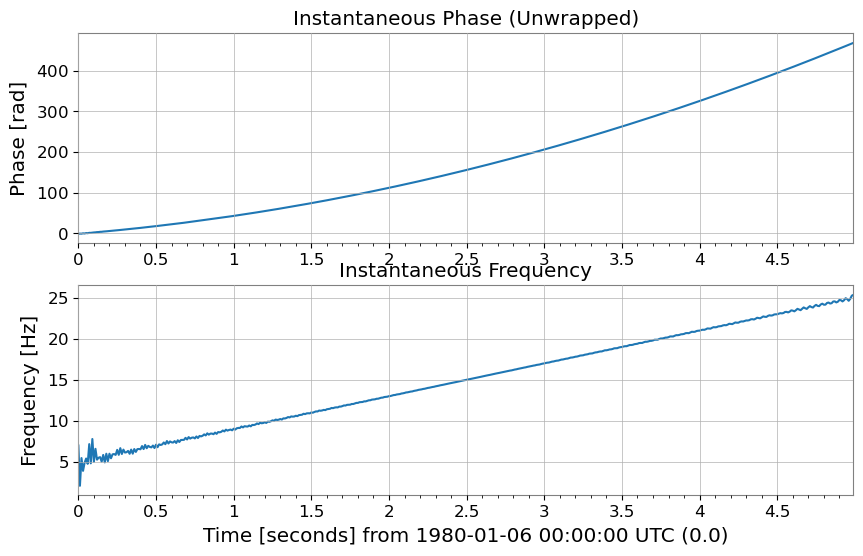

In [3]:
# 瞬時位相 (unwrap=True で位相跳びを解消)
phase_rad = ts2.instantaneous_phase(unwrap=True)
phase_deg = ts2.instantaneous_phase(deg=True, unwrap=True)

# 瞬時周波数
freq = ts2.instantaneous_frequency()

plot = Plot(phase_rad, freq, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].set_ylabel('Phase [rad]')
ax[0].set_title('Instantaneous Phase (Unwrapped)')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Instantaneous Frequency')
plt.show()

### 混合と復調 (Mix-down, Baseband, Lock-in)
特定の周波数成分を抽出したり、直流成分へ落とし込むための機能です。

TimeSeries([1.1132167 , 1.03168715, 0.86032101, 1.14948839,
            1.10646377, 0.85980808, 1.00472246, 1.00303948,
            1.00353419, 1.07398732, 0.85551096, 0.94246084,
            1.30319478, 1.05277656, 1.07378045, 1.10743722,
            0.9112516 , 0.92068457, 1.00025426, 0.97390355,
            1.06282669, 0.88960486, 1.0524744 , 0.96507945,
            1.24356988, 0.87110375, 1.04315321, 0.96899158,
            0.87827312, 1.04105275, 1.02055477, 1.04432355,
            1.09801861, 1.10651464, 1.10713363, 1.02673333,
            1.13280964, 0.94672142, 1.00209959, 1.08849296,
            0.88677442, 1.08202972, 0.98898945, 1.2924761 ,
            0.9272152 , 1.06196322, 0.95394731, 0.93536832,
            1.05387411, 1.19474794]
           unit: V,
           t0: 0.0 s,
           dt: 0.1 s,
           name: Sensor 1,
           channel: None)


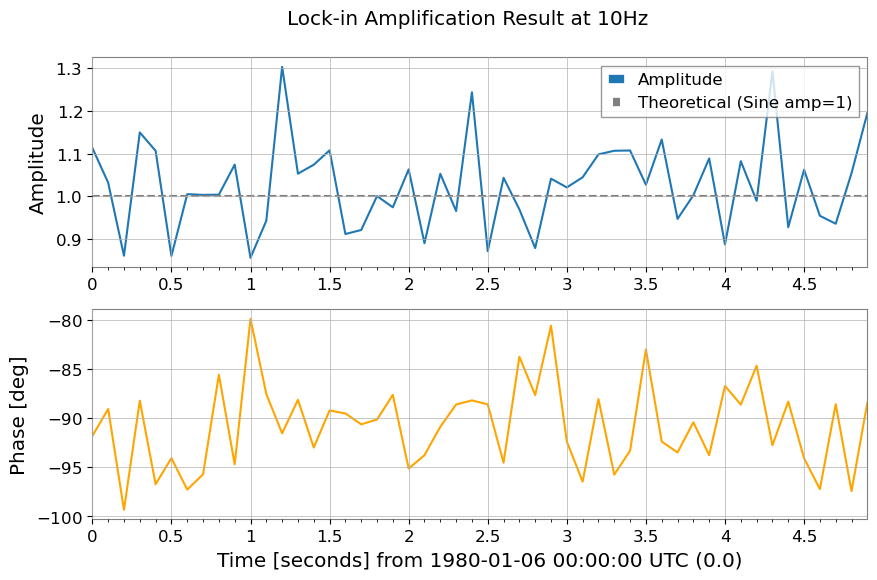

In [4]:
# 1. mix_down: 特定の周波数 f0 で複調 (複素信号になる)
ts_mixed = ts1.mix_down(f0=10)

# 2. baseband: demodulation + lowpass + resampling を一括実行
ts_base = ts1.baseband(f0=10, lowpass=5, output_rate=20)

# 3. lock_in: ロックイン検波 (振幅と位相を抽出)
amp, ph = ts1.lock_in(f0=10, stride=0.1) # 0.1秒ごとの平均を出力
res_complex = ts1.lock_in(f0=10, stride=0.1, output='complex') # 複素数での出力

print(amp)

plot = Plot(amp, ph, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].get_lines()[0].set_label('Amplitude')
ax[0].axhline(1.0, color='gray', linestyle='--', label='Theoretical (Sine amp=1)')
ax[0].set_ylabel('Amplitude')
ax[0].legend()
ax[1].get_lines()[0].set_color('orange')
ax[1].get_lines()[0].set_label('Phase [deg]')
ax[1].set_ylabel('Phase [deg]')
plot.figure.suptitle('Lock-in Amplification Result at 10Hz')
plt.show()

<a id="spectral"></a>
## 3. スペクトル解析と相関

GWpy の機能を継承しつつ、過渡信号向けの `transient` モード FFT や、FFT の直接比による伝達関数計算が追加されています。

### 拡張された FFT
`mode="transient"` を使用すると、ゼロパディングや高速な長さへの調整、左右個別のパディング指定が可能です。

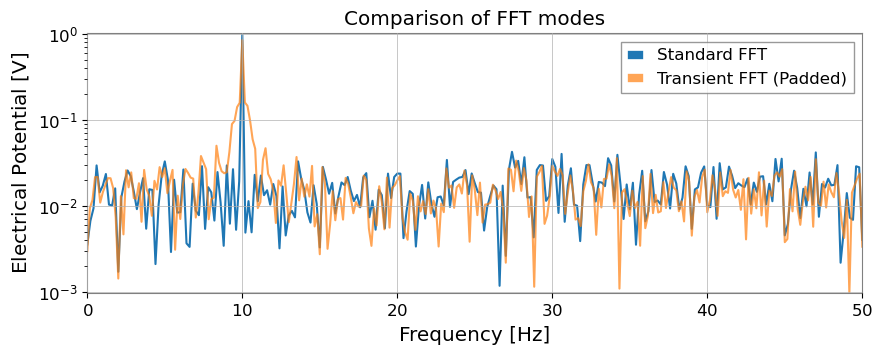

In [5]:
# 通常の FFT (GWpy互換)
fs_gwpy = ts1.fft()

# Transient モード:
# pad_left/right でパディング量を指定。nfft_mode="next_fast_len" で計算効率の良い長さに調整。
fs_trans = ts1.fft(mode="transient", pad_left=0.5, pad_right=0.5, nfft_mode="next_fast_len")

plot = Plot(fs_gwpy.abs(), fs_trans.abs(), yscale='log', xlim=(0, 50), figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('Standard FFT')
ax.get_lines()[1].set_label('Transient FFT (Padded)')
ax.get_lines()[1].set_alpha(0.7)
ax.legend()
ax.set_title('Comparison of FFT modes')
plt.show()

### 伝達関数 (Transfer Function) と相互相関 (xcorr)
`transfer_function` では Welch法 (`method="gwpy"`) だけでなく、FFT の直接比 (`method="fft"`) も選択できます。

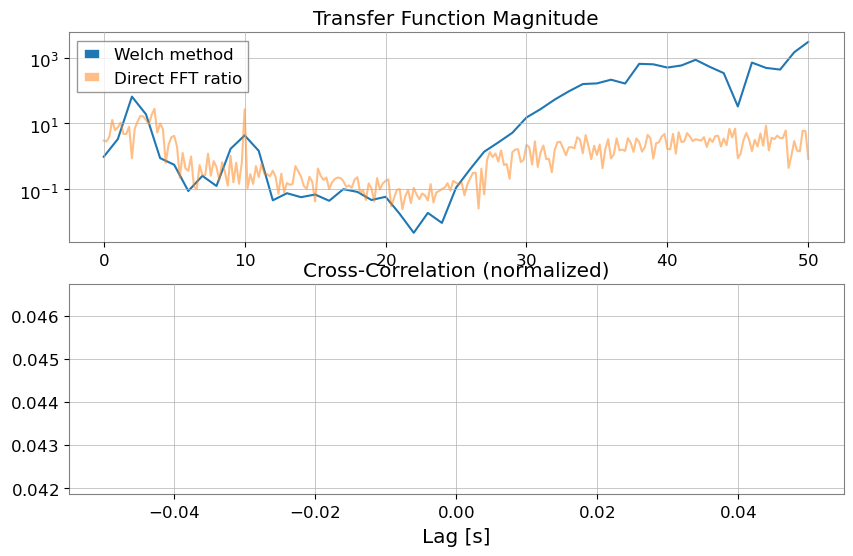

In [6]:
# 伝達関数の計算 (Sensor 1 に対する Chirp Signal の伝達関数)
tf_welch = ts2.transfer_function(ts1, fftlength=1)
tf_fft = ts2.transfer_function(ts1, method="fft") # 全区間FFT比 (過渡応答解析などに有用)

# 相互相関 (xcorr)
corr = ts1.xcorr(ts2, maxlag=0.5, normalize='coeff')

plot = Plot(figsize=(10, 6))
ax1 = plot.add_subplot(2, 1, 1)
ax1.semilogy(tf_welch.frequencies, np.abs(tf_welch), label='Welch method')
ax1.semilogy(tf_fft.frequencies, np.abs(tf_fft), label='Direct FFT ratio', alpha=0.5)
ax1.set_title('Transfer Function Magnitude')
ax1.legend()

ax2 = plot.add_subplot(2, 1, 2)
lag = corr.times.value - corr.t0.value
ax2.plot(lag, corr)
ax2.set_title('Cross-Correlation (normalized)')
ax2.set_xlabel('Lag [s]')
plt.show()

### STLT (Short-Time Laplace Transform)

STLT (Short-Time Laplace Transform) は、信号の時間変化に伴う局所的な構造（対称な2軸を持つ特徴量）を抽出するための変換です。
`gwexpy` では、このような3Dデータ (時間 x 軸1 x 軸2) を扱うために `TimePlaneTransform` クラスを提供しています。

以下は、`stlt` メソッドを使用して STLT を計算し、特定時刻のスライス (`Plane2D`) を抽出する例です。

In [7]:
# データの準備 (デモ用)
import numpy as np
from gwexpy.timeseries import TimeSeries
from gwexpy.plot import Plot

t = np.linspace(0, 10, 1000)
data = TimeSeries(np.sin(2 * np.pi * 1 * t), times=t*u.s, unit='V', name='Demo Data')

# STLT の実行
# stride: 時間ステップ, window: 解析ウィンドウ長
stlt_result = data.stlt(stride='0.5s', window='2s')

print(f"Kind: {stlt_result.kind}")
print(f"Shape: {stlt_result.shape} (Time x Axis1 x Axis2)")
print(f"Time Axis: {len(stlt_result.times)} steps")

# 特定時刻 (t=5.0s) の平面を抽出
plane_at_5s = stlt_result.at_time(5.0 * u.s)
print(f"Plane at 5.0s shape: {plane_at_5s.shape}")

# Plane2D としての振る舞いを確認
print(f"Axis 1: {plane_at_5s.axis1.name}")
print(f"Axis 2: {plane_at_5s.axis2.name}")

Kind: stlt
Shape: (17, 1, 101) (Time x Axis1 x Axis2)
Time Axis: 17 steps
Plane at 5.0s shape: (1, 101)
Axis 1: sigma
Axis 2: frequency


## 4. Hilbert-Huang Transform (HHT)
非線形・非定常信号解析のためのヒルベルト・ファン変換 (HHT) 機能です。
Empirical Mode Decomposition (EMD) とヒルベルトスペクトル解析を組み合わせます。

Extracted IMFs: ['IMF1', 'IMF2', 'IMF3', 'residual']


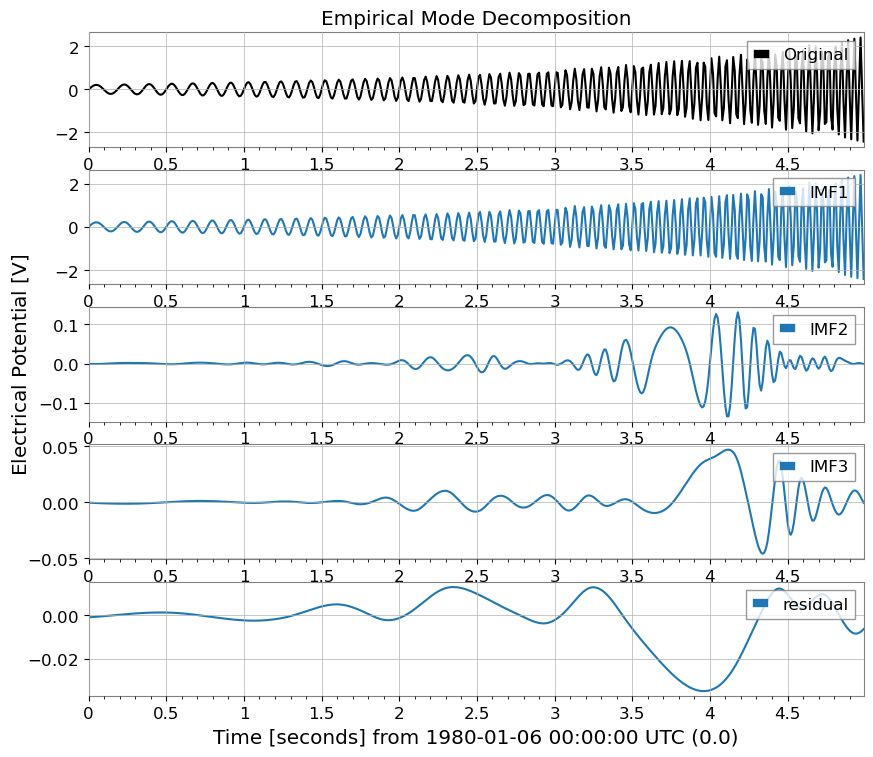

In [8]:
# HHT (Hilbert-Huang Transform)
# Empirical Mode Decomposition (EMD) を実行し、IMFs (Intrinsic Mode Functions) を抽出
# 注意: 実行には PyEMD (EMD-signal) が必要です: `pip install EMD-signal`

try:
    # EMDの実行 (戻り値は辞書)
    # method="emd" (標準EMD) または "eemd" (Ensemble EMD)
    # ここでは ts2 (Chirp信号を含む例) を使用します
    imfs = ts2.emd(method="emd", max_imf=3)

    print(f"Extracted IMFs: {list(imfs.keys())}")

    # IMFのプロット
    sorted_keys = sorted([k for k in imfs.keys() if k.startswith("IMF")], key=lambda x: int(x[3:]))
    if "residual" in imfs:
        sorted_keys.append("residual")

    # gwexpy.plot.Plot を使用して一括プロット
    plot_data = [ts2] + [imfs[k] for k in sorted_keys]
    plot = Plot(*plot_data, separate=True, sharex=True, figsize=(10, 8))

    # Originalの設定
    ax0 = plot.axes[0]
    ax0.get_lines()[0].set_label("Original")
    ax0.get_lines()[0].set_color('black')
    ax0.legend(loc="upper right")
    ax0.set_title("Empirical Mode Decomposition")

    # IMFsの設定
    for i, key in enumerate(sorted_keys):
        ax = plot.axes[i+1]
        ax.get_lines()[0].set_label(key)
        ax.legend(loc="upper right")

    plt.show()

except ImportError:
    print("EMD-signal not installed. Skipping HHT demo.")
except Exception as e:
    print(f"HHT Error: {e}")


<a id="stats"></a>
## 5. 統計・前処理

欠損値補完、標準化、ARIMAモデル、ハースト指数、およびローリング統計量が TimeSeries メソッドとして利用可能です。

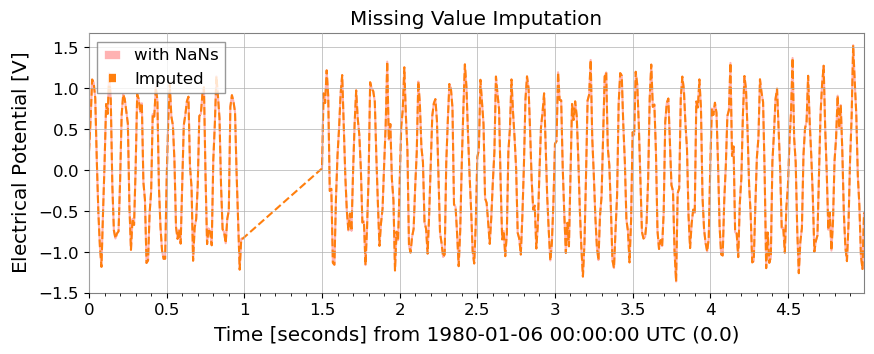

In [9]:
# 欠損値を含むデータのテスト
ts_nan = ts1.copy()
ts_nan.value[100:150] = np.nan

# 1. impute: 欠損値補完 (interpolation など)
ts_imputed = ts_nan.impute(method='interpolate')

# 2. standardize: 標準化 (z-score, robust など)
ts_z = ts1.standardize(method='zscore')
ts_robust = ts1.standardize(method='zscore', robust=True) # Median/IQRを使用

plot = Plot(ts_nan, ts_imputed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('with NaNs')
ax.get_lines()[0].set_color('red')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label('Imputed')
ax.get_lines()[1].set_linestyle('--')
ax.legend()
ax.set_title('Missing Value Imputation')
plt.show()

### ピーク検出 (Find Peaks)
`scipy.signal.find_peaks` をラップし、時系列データからピークを検出します。

Found 9 peaks
First 5 peaks: TimeSeries([0.24297757, 0.33159257, 0.44513676, 0.58819005,
            0.77322212]
           unit: V,
           t0: 0.39 s,
           dt: 0.64 s,
           name: Chirp Signal_peaks,
           channel: None)


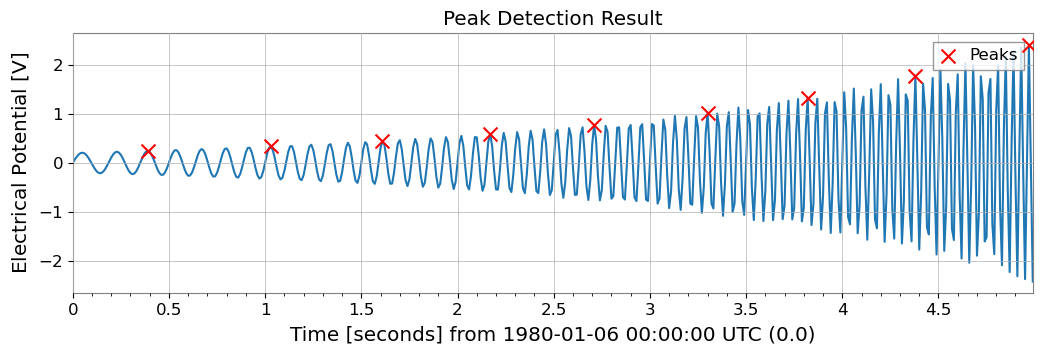

In [10]:
# ピーク検出 (Find Peaks)
# height, threshold, distance, prominence, width などのパラメータを指定可能
# 単位付きの閾値指定も可能です

# ts2 (Chirp + Sine) からピークを探す
peaks, props = ts2.find_peaks(height=0.0, distance=50)

print(f"Found {len(peaks)} peaks")
if len(peaks) > 0:
    print("First 5 peaks:", peaks[:5])

# プロット
plot = ts2.plot(figsize=(12, 4))
ax = plot.gca()
ax.scatter(peaks.times.value, peaks.value, marker="x", color="red", s=100, label="Peaks", zorder=10)
ax.legend(loc="upper right")
ax.set_title("Peak Detection Result")
plt.show()



### ARIMAモデルとハースト指数
※ これらの機能には `statsmodels`, `hurst` 等のライブラリが必要です。

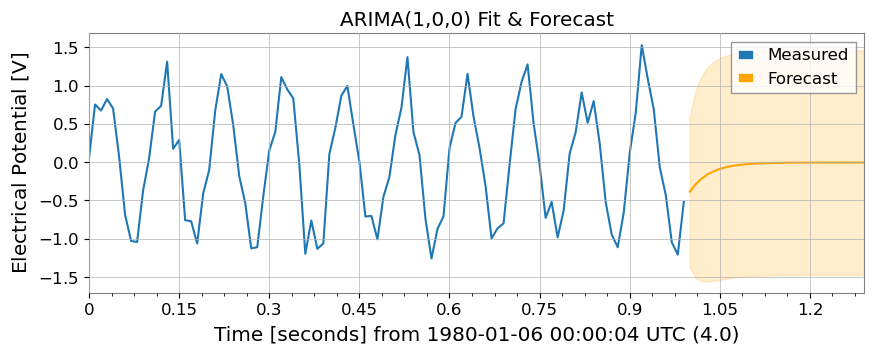

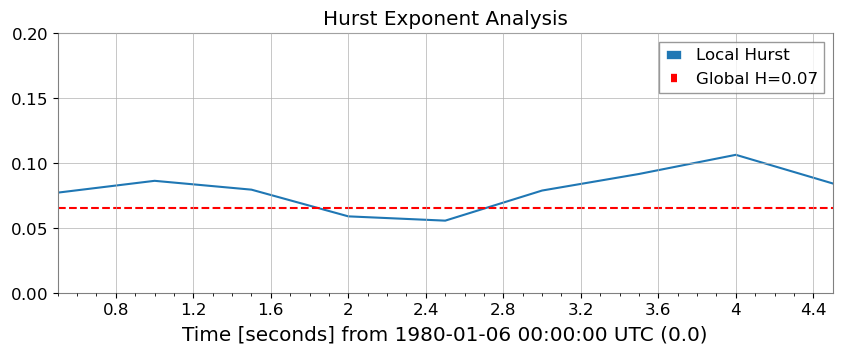

In [11]:
try:
    # 3. fit_arima: ARIMA(1,0,0) フィッティングと予測
    model = ts1.fit_arima(order=(1, 0, 0))
    resid = model.residuals()
    forecast, conf = model.forecast(steps=30)

    plot = Plot(ts1.tail(100), forecast, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label('Measured')
    ax.get_lines()[1].set_label('Forecast')
    ax.get_lines()[1].set_color('orange')

    # Fill between
    ax.fill_between(conf['lower'].times.value, conf['lower'].value, conf['upper'].value, alpha=0.2, color='orange')

    ax.set_title('ARIMA(1,0,0) Fit & Forecast')
    ax.legend()
    plt.show()
except Exception as e:
    print(f"ARIMA skipping: {e}")

try:
    # 4. hurst / local_hurst: ハースト指数 (長距離相関の指標)
    h_val = ts1.hurst()
    h_detail = ts1.hurst(return_details=True) # 詳細情報付き
    h_local = ts1.local_hurst(window=1.0) # 1秒窓での推移

    plot = Plot(h_local, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label('Local Hurst')
    ax.axhline(h_val, color='red', linestyle='--', label=f'Global H={h_val:.2f}')
    ax.set_ylim(0, 0.2)
    ax.set_title('Hurst Exponent Analysis')
    ax.legend()
    plt.show()
except Exception as e:
    print(f"Hurst skipping: {e}")

### ローリング統計量 (Rolling Statistics)
Pandas と同様の使い勝手で、`rolling_mean`, `std`, `median`, `min`, `max` が利用できます。

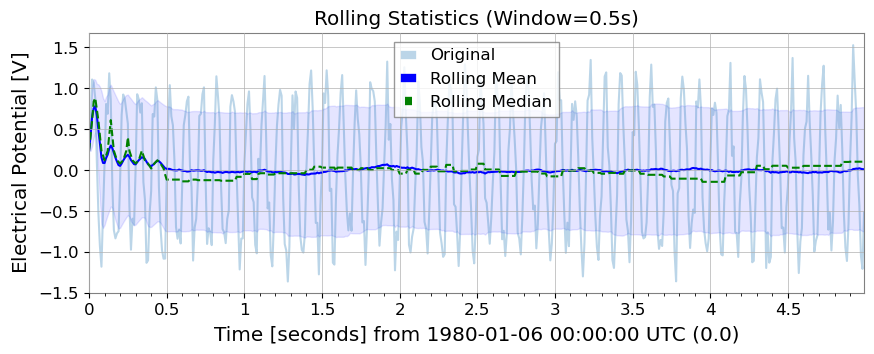

In [12]:
rw = 0.5 * u.s # 0.5秒窓
rmean = ts1.rolling_mean(rw)
rstd = ts1.rolling_std(rw)
rmed = ts1.rolling_median(rw)
rmin = ts1.rolling_min(rw)
rmax = ts1.rolling_max(rw)

plot = Plot(ts1, rmean, rmed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('Original')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label('Rolling Mean')
ax.get_lines()[1].set_color('blue')
ax.get_lines()[2].set_label('Rolling Median')
ax.get_lines()[2].set_color('green')
ax.get_lines()[2].set_linestyle('--')
ax.fill_between(rmean.times.value, rmean.value - rstd.value, rmean.value + rstd.value, alpha=0.1, color='blue')
ax.legend()
ax.set_title('Rolling Statistics (Window=0.5s)')
plt.show()

<a id="resampling"></a>
## 6. リサンプリングと再インデックス

`asfreq` メソッドによる固定グリッドへの割り当てや、`resample` メソッドでの「時間ビン集計」が可能になりました。

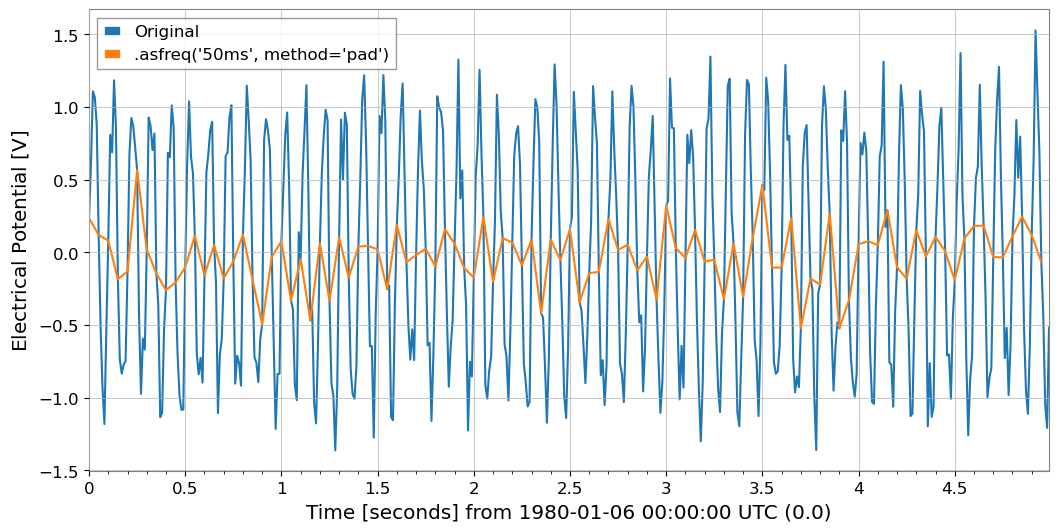

In [13]:
# 1. asfreq: Pandasライクな名付け規則 ('50ms' など) で再インデックス
ts_reindexed = ts1.asfreq('50ms', method='pad')
Plot(ts1, ts_reindexed)
plt.legend(['Original', ".asfreq('50ms', method='pad')"])

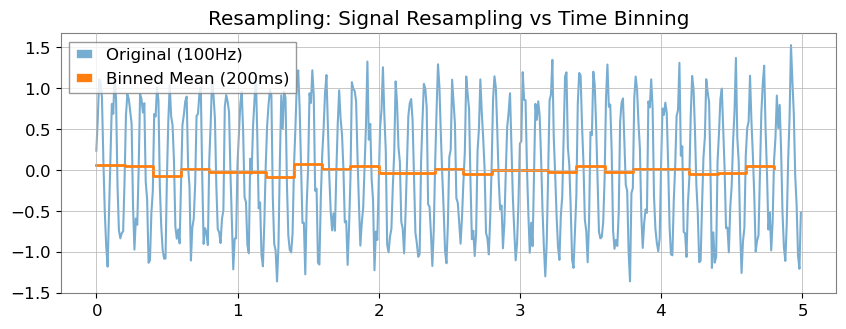

In [14]:
# 2. resample:
# 数値 (10Hz) を指定すると信号処理的なリサンプリング (GWpy標準)
ts_sig = ts1.resample(10)
# 文字列 ('200ms') を指定すると、その時間幅のビンごとの統計量をとる (新機能)
ts_binned = ts1.resample('200ms') # デフォルトは mean

# Plot doesn't have a direct 'step' method equivalent in args, so we use ax.step or pass to plot
# However, kwarg 'drawstyle'='steps-post' works in plot()? gwpy Plot wraps matplotlib.
# Let's assume we can modify axes after creation or use standard plot for simplicity if appropriate, but step is specific.
# Better strategy: Create Plot instance, then use ax.step
plot = Plot(figsize=(10, 4))
ax = plot.gca()
ax.plot(ts1, alpha=0.6, label='Original (100Hz)')
ax.step(ts_binned.times, ts_binned.value, where='post', label='Binned Mean (200ms)', linewidth=2)
ax.legend()
ax.set_title('Resampling: Signal Resampling vs Time Binning')
plt.show()

## 7. 関数によるフィッティング

`gwexpy` では `iminuit` をベースとした強力なフィッティング機能を提供しています。GWpy の元のクラスを汚染しないよう、`.fit()` メソッドはオプトイン方式になっています。

Fit valid: True
Parameters: {'A': 1.0097444781089215, 'tau': 0.10248947423614552, 'f': 10.009929152809281, 'phi': 0.4859780804529429}


<AxesSubplot: ylabel='Amplitude []'>

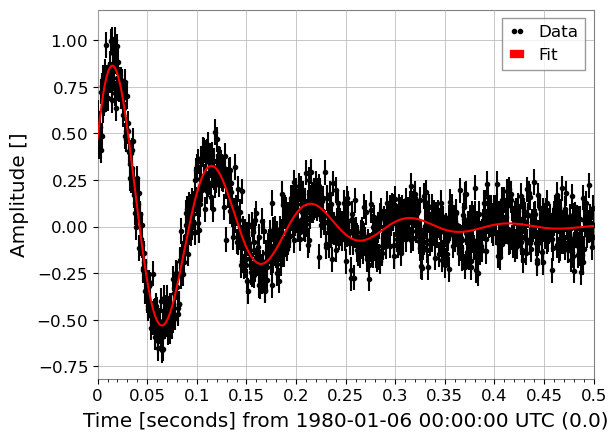

In [15]:
# 例：減衰振動モデルでフィッティング
from gwexpy.fitting.models import damped_oscillation

# テストデータの作成
t = np.linspace(0, 0.5, 1000)
y = damped_oscillation(t, A=1.0, tau=0.1, f=10, phi=0.5) + np.random.normal(0, 0.1, len(t))
ts_fit = TimeSeries(y, times=t)

# フィッティングの実行
result = ts_fit.fit('damped_oscillation', p0={'A': 0.8, 'tau': 0.14, 'f': 9, 'phi': 0}, sigma=0.068)

print("Fit valid:", result.minuit.valid)
print("Parameters:", result.params)

# 結果のプロット
result.plot()

<a id="interop"></a>
## 8. 相互運用性

主要なデータサイエンス・機械学習ライブラリとの相互変換が非常にスムーズです。

In [16]:
# Pandas & Xarray
try:
    df = ts1.to_pandas(index='datetime')
    ts_p = TimeSeries.from_pandas(df)
    print("Pandas interop OK")
    display(df)
except ImportError: pass

try:
    xr = ts1.to_xarray()
    ts_xr = TimeSeries.from_xarray(xr)
    print("Xarray interop OK")
    display(xr)
except ImportError: pass


Pandas interop OK


time_utc
1980-01-06 00:00:19+00:00           0.236299
1980-01-06 00:00:19.010000+00:00    0.610884
1980-01-06 00:00:19.020000+00:00    1.108105
1980-01-06 00:00:19.030000+00:00    1.067280
1980-01-06 00:00:19.040000+00:00    0.881227
                                      ...   
1980-01-06 00:00:23.950000+00:00   -0.066986
1980-01-06 00:00:23.960000+00:00   -0.430546
1980-01-06 00:00:23.970000+00:00   -1.045431
1980-01-06 00:00:23.980000+00:00   -1.207246
1980-01-06 00:00:23.990000+00:00   -0.518956
Name: Sensor 1, Length: 500, dtype: float64

Xarray interop OK


<xarray.DataArray 'Sensor 1' (time: 500)> Size: 4kB
array([ 0.23629881,  0.61088414,  1.10810482, ..., -1.0454311 ,
       -1.2072462 , -0.51895625])
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-06T00:00:19 ... 1980-01-06T00:...
Attributes:
    unit:        V
    name:        Sensor 1
    channel:     None
    epoch:       0.0
    time_coord:  datetime

In [17]:
# SQLite (シリアライズ保存)
import sqlite3
with sqlite3.connect(':memory:') as conn:
    ts1.to_sqlite(conn, series_id='my_sensor')
    ts_sql = TimeSeries.from_sqlite(conn, series_id='my_sensor')
    print(f"SQLite interop OK: {ts_sql.name}")
    display(conn)


SQLite interop OK: my_sensor


In [18]:
# Deep Learning (Torch)
try:
    import torch
    t_torch = ts1.to_torch()
    ts_f_torch = TimeSeries.from_torch(t_torch, t0=ts1.t0, dt=ts1.dt)
    print(f"Torch interop OK (Shape: {t_torch.shape})")
    display(t_torch)
except ImportError: pass


Torch interop OK (Shape: torch.Size([500]))


tensor([ 0.2363,  0.6109,  1.1081,  1.0673,  0.8812,  0.1198, -0.5133, -0.9296,
        -1.1808, -0.5249,  0.0803,  0.8086,  0.6882,  1.1836,  0.8539, -0.1839,
        -0.7351, -0.8346, -0.7731, -0.7476, -0.1306,  0.6758,  0.9244,  0.8699,
         0.7222,  0.5669, -0.4392, -0.9732, -0.5935, -0.6684,  0.0197,  0.9273,
         0.8689,  0.7034,  0.8175, -0.1447, -0.3603, -1.1337, -1.1036, -0.5270,
        -0.2598,  0.6855,  0.6545,  1.0111,  0.8552, -0.2061, -0.6931, -0.9793,
        -1.0829, -1.0818, -0.1016,  0.6075,  1.0390,  0.6579,  0.5480,  0.1140,
        -0.6949, -0.8389, -0.7262, -0.8967, -0.1578,  0.5494,  0.6743,  0.8409,
         0.8981,  0.0493, -0.2082, -1.1059, -0.7030, -0.5960, -0.1784,  0.6618,
         0.6881,  0.9278,  1.0115, -0.0625, -0.9029, -0.7108, -0.7612, -0.9173,
         0.1210,  0.5615,  1.1467,  0.9075,  0.6338, -0.1888, -0.7213, -0.7602,
        -0.8928, -0.5963, -0.4930,  0.7745,  0.9167,  0.8385,  0.7102, -0.0302,
        -0.6254, -1.2146, -0.8372, -0.83

In [19]:
# Deep Learning (TensorFlow)
try:
    import tensorflow as tf
    t_tf = ts1.to_tensorflow()
    ts_f_tf = TimeSeries.from_tensorflow(t_tf, t0=ts1.t0, dt=ts1.dt)
    print("TensorFlow interop OK")
    display(t_tf)
except ImportError: pass


2026-01-06 22:15:16.220290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-06 22:15:23.902333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow interop OK


2026-01-06 22:15:38.174559: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<tf.Tensor: shape=(500,), dtype=float64, numpy=
array([ 0.23629881,  0.61088414,  1.10810482, ..., -1.0454311 ,
       -1.2072462 , -0.51895625])>

In [20]:
# ObsPy (地震波形・時系列解析)
try:
    import obspy
    tr = ts1.to_obspy()
    ts_f_obspy = TimeSeries.from_obspy(tr)
    print(f"ObsPy interop OK: {tr.id}")
    display(tr)
except ImportError: pass


ObsPy interop OK: .Sensor 1..


.Sensor 1.. | 1980-01-06T00:00:00.000000Z - 1980-01-06T00:00:04.990000Z | 100.0 Hz, 500 samples

### まとめ

`gwexpy` の `TimeSeries` クラスは、従来の GWpy の使い勝手はそのままに、より現代的で広範な分析ニーズに応える機能を備えています。
是非、皆さんのプロジェクトで活用してください！